# Full Pipeline for OCR and Fuzzy Matching

**(June 11, 2024)**

In [1]:
from tqdm.notebook import tqdm
import string
import numpy as np
import pandas as pd
from rapidfuzz import fuzz

In [2]:
from dotenv import load_dotenv
from openai import OpenAI
import os

import time
import pprint 

load_dotenv() 
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
# starting Open AI client
client = OpenAI(api_key=OPENAI_API_KEY)

In [3]:
# reading in election data
election_data = pd.read_csv('../raw_feb_23_city_wide.csv')

/var/folders/c4/fvxhsb8j6kb6c97612_b98k00000gn/T/ipykernel_89442/1172773266.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  election_data = pd.read_csv('../raw_feb_23_city_wide.csv')


In [4]:
def score_function_fuzz(guess_full_name, full_name_list):

    full_name_score_dict = dict()
    for idx in range(len(full_name_list)):

        # getting full name for row
        name_row = str(full_name_list[idx])

        # lowering strings    
        name_row = name_row.lower() 
        guess_full_name = guess_full_name.lower()
    
        # compiling scores
        final_score = fuzz.ratio(guess_full_name, name_row)/100
        full_name_score_dict[idx] = final_score

    # sorting dictionary
    sorted_dictionary = dict(sorted(full_name_score_dict.items(), reverse=True, key=lambda item: item[1]))

    # top five key value pairs (indices and scores)
    indices_scores_list = list(sorted_dictionary.items())[:5]

    return indices_scores_list  

In [5]:
# displaying last and first name only
election_data[['Last_Name', 'First_Name']]

Last_Name First_Name
0       A Blessing    Rebecca
1         A-Jaoudi     Edward
2           Aaberg  Elizabeth
3             Aaby       Erik
4             Aaby  Katherine
...            ...        ...
520556     Zytnick   Jonathon
520557     Zytnick       Kiva
520558   Zywokarte    Michael
520559   Zywokarte     Sandra
520560  Zyznieuski   Nicholas

[520561 rows x 2 columns]

In [6]:
# generating list of names
full_name_list = [str(char1) + ' ' + str(char2) for char1, char2 in zip(list(election_data['First_Name']), list(election_data['Last_Name']))]

In [7]:
# finding elmements in election database that are similar to a given string
score_function_fuzz('Alexandra Karabatos', full_name_list)

[(247654, 0.9743589743589743),
 (247699, 0.85),
 (407872, 0.8333333333333335),
 (261560, 0.8235294117647058),
 (261711, 0.8235294117647058)]

In [8]:
from ocr_helper_functions import extract_signature_info

# printing resulting data
start_time = time.time()

# ocr extraction of the text
resulting_data = extract_signature_info('../page-0.jpg', verbose = False)

# pretty printing the data
pprint.pprint(resulting_data)
print()
end_time = time.time()

print(f'Elapsed Time: {end_time-start_time:.3f} secs')

[{'Address': '1836 Montello Ave NE Washington, DC 20002',
  'Date': '11/8/22',
  'Name': 'James Hatch',
  'Ward': '5'},
 {'Address': '1152 3rd St NW Washington, DC 20001',
  'Date': '11/8/22',
  'Name': 'Lynn Ly',
  'Ward': 'E'},
 {'Address': '1344 H St NE Washington, DC 20002',
  'Date': '11/8/22',
  'Name': 'Bruce McHugh',
  'Ward': 'C'},
 {'Address': '22 M St NE Apt 611 Washington, DC 20002',
  'Date': '11/8/22',
  'Name': 'Liu Ming',
  'Ward': '6'},
 {'Address': '1300 L St NW Apt 320 Washington, DC 20005',
  'Date': '11/8/22',
  'Name': 'Alexandra Karabatsos',
  'Ward': '2'}]

Elapsed Time: 13.490 secs


In [17]:
# Testing the element
election_data.iloc[247654]['First_Name']

'Alexandra'

In [18]:
print('%s %s' % ('Food', 'Item'))

Food Item


In [23]:

data_list = list()
for dict_ in resulting_data:
    data_dict = dict()
    print(dict_['Name'])
    # finding elmements in election database that are similar to a given string
    high_match_ids = score_function_fuzz(dict_['Name'], full_name_list)    
    id_, score_ = high_match_ids[0]
    print('%s %s' % (election_data.iloc[id_]['First_Name'], election_data.iloc[id_]['Last_Name']))
    print(score_)
    print()
    data_dict['OCR NAME'] = dict_['Name']
    data_dict['MATCHED NAME'] = election_data.iloc[id_]['First_Name'] + ' ' + election_data.iloc[id_]['Last_Name']
    data_dict['SCORE'] = score_
    data_list.append(data_dict)


James Hatch
James Hatch
1.0

Lynn Ly
Lynn Ly
1.0

Bruce McWilliams
Bruce McWilliams
1.0

Liu Ming
Liu Ching
0.8235294117647058

Alexandra Karabatos
Alexandra Karabatsos
0.9743589743589743



In [24]:
pd.DataFrame(data_list)

OCR NAME          MATCHED NAME     SCORE
0          James Hatch           James Hatch  1.000000
1              Lynn Ly               Lynn Ly  1.000000
2     Bruce McWilliams      Bruce McWilliams  1.000000
3             Liu Ming             Liu Ching  0.823529
4  Alexandra Karabatos  Alexandra Karabatsos  0.974359

In [28]:
# full function

def produce_match_df(filename, verbose = False):

    resulting_data = extract_signature_info(filename, verbose = verbose)    

    matched_list = list()
    for dict_ in resulting_data:
        temp_dict = dict()
        high_match_ids = score_function_fuzz(dict_['Name'], full_name_list)    
        id_, score_ = high_match_ids[0]
        temp_dict['OCR NAME'] = dict_['Name']
        temp_dict['MATCHED NAME'] = election_data.iloc[id_]['First_Name'] + ' ' + election_data.iloc[id_]['Last_Name']
        temp_dict['SCORE'] = score_
        matched_list.append(temp_dict)

    df = pd.DataFrame(data_list)

    return df


In [26]:
from ocr_helper_functions import extract_signature_info

# printing resulting data
start_time = time.time()

# ocr extraction of the text
resulting_data = extract_signature_info('../page-0.jpg', verbose = False)

# pretty printing the data
pprint.pprint(resulting_data)
print()
end_time = time.time()

print(f'Elapsed Time: {end_time-start_time:.3f} secs')

[{'Address': '1631 Maryland Avenue NE',
  'Date': '11/8/22',
  'Name': 'James Hatch',
  'Ward': '5'},
 {'Address': '1732 Irving St NW #103',
  'Date': '11/8/22',
  'Name': 'Lynn Ly',
  'Ward': '1'},
 {'Address': '1844 3rd St NW',
  'Date': '11/8/22',
  'Name': 'Bruce McMulkin',
  'Ward': '0'},
 {'Address': '22 M ST NE #601',
  'Date': '11/8/22',
  'Name': 'Liu Ming',
  'Ward': '6'},
 {'Address': '3000 Connecticut Avenue',
  'Date': '11/8/22',
  'Name': 'Alexandra Karabatos',
  'Ward': '0'}]

Elapsed Time: 11.829 secs


In [29]:
produce_match_df('../page-0.jpg', verbose = False)

OCR NAME          MATCHED NAME     SCORE
0          James Hatch           James Hatch  1.000000
1              Lynn Ly               Lynn Ly  1.000000
2     Bruce McWilliams      Bruce McWilliams  1.000000
3             Liu Ming             Liu Ching  0.823529
4  Alexandra Karabatos  Alexandra Karabatsos  0.974359

In [ ]:
from pdf2image import convert_from_path
pages = convert_from_path('pdf_file', 500)

In [10]:
from pdf2image import convert_from_bytes
from tqdm.notebook import tqdm

import sys
images = convert_from_bytes(open('INITIATIVE 82_pages_7901_7971.pdf', "rb").read())
# for i in tqdm(range(len(images))):
#     if i<10:
#         str_i = '0'+str(i)
#     else:
#         str_i = str(i)
#     images[i].save(f"source_pdfs/page-{str_i}.jpg")

In [12]:
import base64

In [ ]:
# Function to encode the image
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

In [15]:
from PIL import Image

In [17]:
# Image.open(images[0])

In [14]:
base64.b64encode(images[0].read()).decode('utf-8')

AttributeError: 'PpmImageFile' object has no attribute 'read'

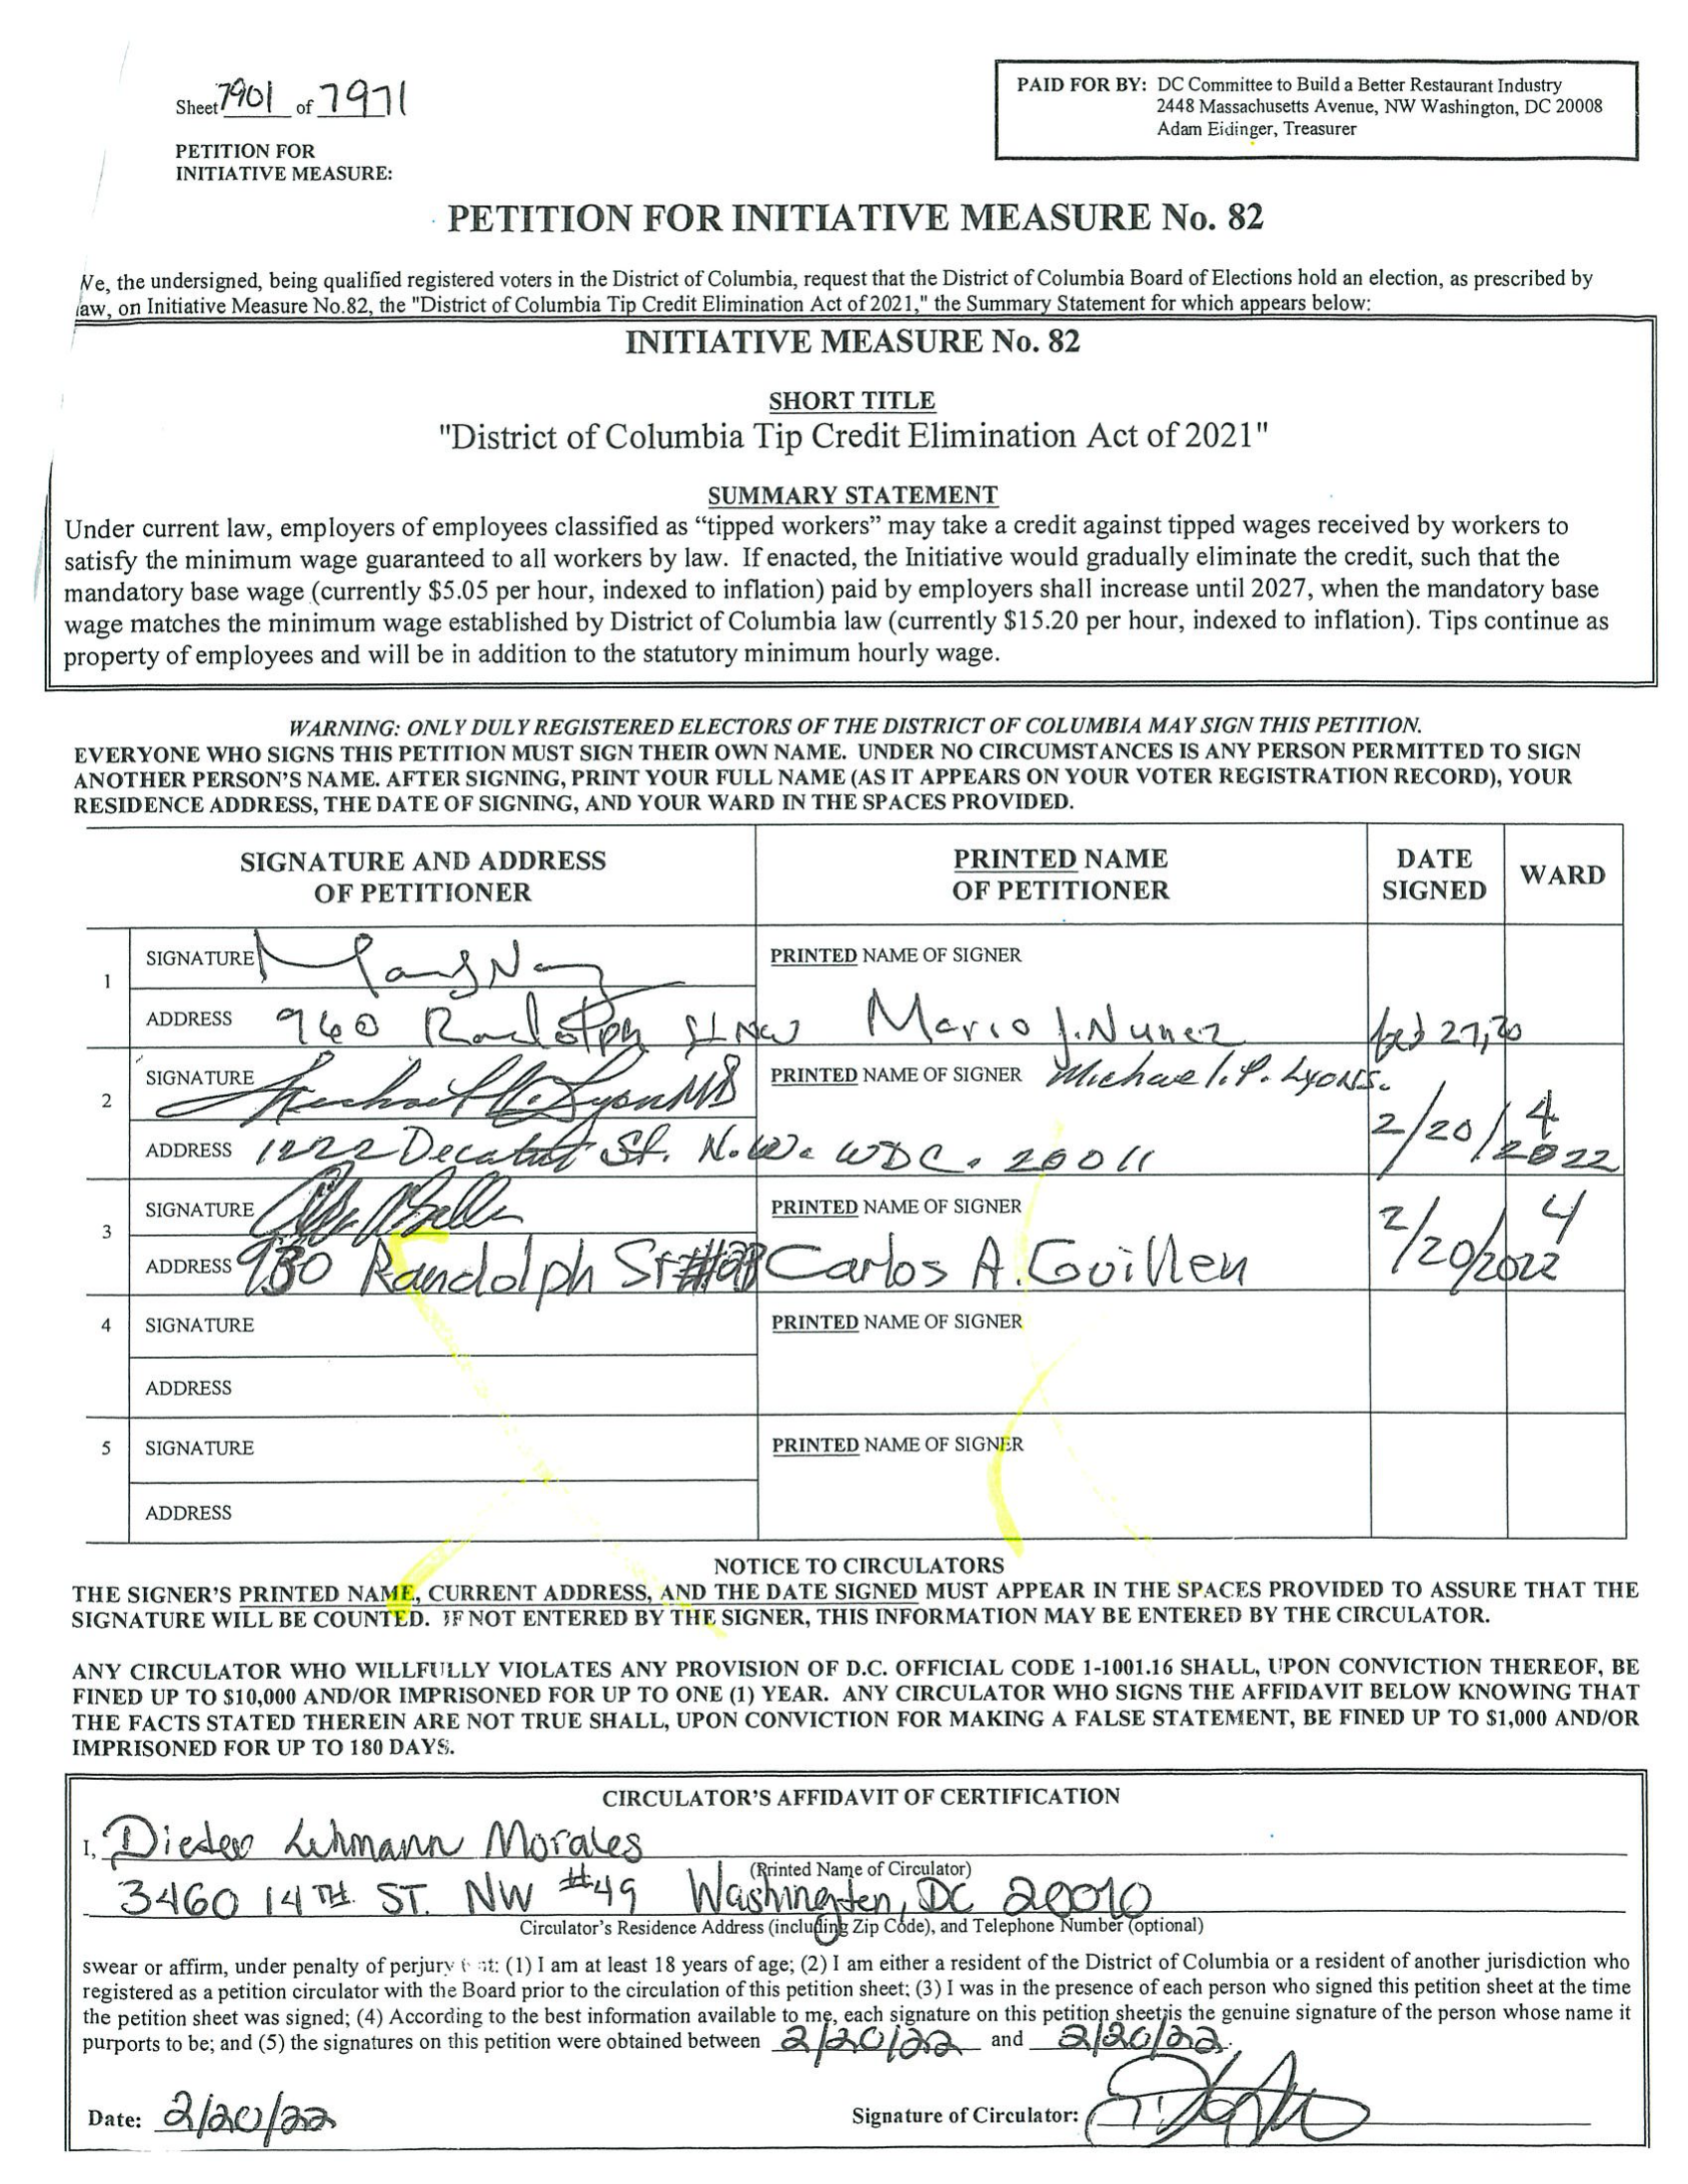

In [11]:
images[0]